<a href="https://colab.research.google.com/github/sowrabh-adiga/cybersec/blob/main/side_channel_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import time
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from collections import Counter

In [2]:
# The vulnerable password check function, this cell is assumed to be a external site we are trying to access
password = "9875"

def unlock(key):
    """
    Simulates a password verification process vulnerable to timing attacks.
    """
    if len(key) != len(password):
        return False

    for i in range(len(key)):
        if key[i] == password[i]:
            continue
        else:
            return False
    return True

Starting best-estimate-experiment: 10 runs, each with 500000 trials.
The final result will be the most common guess across all runs.

--- Running Best_Estimate-Experiment Iteration 1/10 ---


Testing '9000': 100%|██████████| 500000/500000 [00:00<00:00, 1207924.84it/s]


Iteration 1 best guess: 5

--- Running Best_Estimate-Experiment Iteration 2/10 ---


Testing '9000': 100%|██████████| 500000/500000 [00:00<00:00, 1226112.85it/s]


Iteration 2 best guess: 7

--- Running Best_Estimate-Experiment Iteration 3/10 ---


Testing '9000': 100%|██████████| 500000/500000 [00:00<00:00, 1228029.12it/s]


Iteration 3 best guess: 9

--- Running Best_Estimate-Experiment Iteration 4/10 ---


Testing '9000': 100%|██████████| 500000/500000 [00:00<00:00, 1117109.55it/s]


Iteration 4 best guess: 9

--- Running Best_Estimate-Experiment Iteration 5/10 ---


Testing '9000': 100%|██████████| 500000/500000 [00:00<00:00, 1201361.56it/s]


Iteration 5 best guess: 0

--- Running Best_Estimate-Experiment Iteration 6/10 ---


Testing '9000': 100%|██████████| 500000/500000 [00:00<00:00, 1208044.52it/s]


Iteration 6 best guess: 9

--- Running Best_Estimate-Experiment Iteration 7/10 ---


Testing '9000': 100%|██████████| 500000/500000 [00:00<00:00, 753898.54it/s]


Iteration 7 best guess: 9

--- Running Best_Estimate-Experiment Iteration 8/10 ---


Testing '9000': 100%|██████████| 500000/500000 [00:00<00:00, 1217679.40it/s]


Iteration 8 best guess: 0

--- Running Best_Estimate-Experiment Iteration 9/10 ---


Testing '9000': 100%|██████████| 500000/500000 [00:00<00:00, 1240295.99it/s]


Iteration 9 best guess: 9

--- Running Best_Estimate-Experiment Iteration 10/10 ---


Testing '9000': 100%|██████████| 500000/500000 [00:00<00:00, 1241436.22it/s]


Iteration 10 best guess: 5

--- Final Results ---
All guesses from the best--experiment: ['5', '7', '9', '9', '0', '9', '9', '0', '9', '5']
Frequency of guesses: Counter({'9': 5, '5': 2, '0': 2, '7': 1})

The most frequent guess across all 10 runs is: '9'
The actual first digit of the password is: '9'


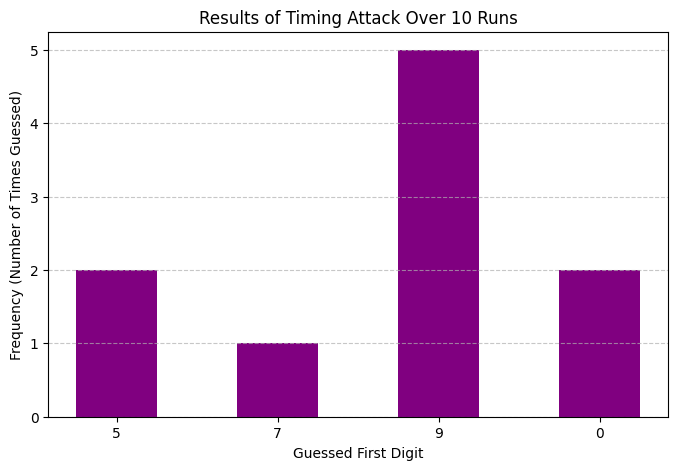

In [3]:
# Function to run a single digit simulation and return the best guess
# first try with mean resulted im outliers swinging the results very frquently
# just median also swings values but less frequent as compared to mean
# in this approch I combined the median with max occurance in estimates (not mode)
# first find median delay for 10 combinations, 10 times and find the max number of times a number has come up in the 10 times simulation
def run_single_simulation(numTrials, passwordLen):
    """Runs a single timing simulation and returns the most likely first digit based on median time.

    Median selected as metric to rule out any outliers due to network or execution latency"""
    medianTimes = {}

    for firstDigit in range(10):
        testKey = str(firstDigit) + "0" * (passwordLen - 1)
        trialTimes = []

        # Using tqdm for a progress bar for each set of trials
        for _ in tqdm(range(numTrials), desc=f"Testing '{testKey}'"):
            startTime = time.perf_counter()
            unlock(testKey)
            endTime = time.perf_counter()
            trialTimes.append(endTime - startTime)

        medianTimes[testKey] = np.median(trialTimes)

    # Find the key with the highest median time for this run
    estimatedKey = max(medianTimes, key=medianTimes.get)
    return estimatedKey[0] # Return just the digit

# 3. The main "best_estimate-experiment" loop
numTrials = 500000
bestEstimateRuns = 10
allGuesses = []

print(f"Starting best-estimate-experiment: {bestEstimateRuns} runs, each with {numTrials} trials.")
print("The final result will be the most common guess across all runs.\n")

for i in range(bestEstimateRuns):
    print(f"--- Running Best_Estimate-Experiment Iteration {i + 1}/{bestEstimateRuns} ---")
    bestGuess = run_single_simulation(numTrials, len(password))
    allGuesses.append(bestGuess)
    print(f"Iteration {i + 1} best guess: {bestGuess}\n")

# 4. Analyze the results from all the runs
guessCounts = Counter(allGuesses)
mostCommonGuess = guessCounts.most_common(1)[0][0]

print("--- Final Results ---")
print("All guesses from the best--experiment:", allGuesses)
print("Frequency of guesses:", guessCounts)
print(f"\nThe most frequent guess across all {bestEstimateRuns} runs is: '{mostCommonGuess}'")
print(f"The actual first digit of the password is: '{password[0]}'")

# Optional: Plotting the frequency of the guesses
labels, values = zip(*guessCounts.items())
indexes = np.arange(len(labels))
width = 0.5

plt.figure(figsize=(8, 5))
plt.bar(indexes, values, width, color='purple')
plt.xticks(indexes, labels)
plt.xlabel('Guessed First Digit')
plt.ylabel('Frequency (Number of Times Guessed)')
plt.title(f'Results of Timing Attack Over {bestEstimateRuns} Runs')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [21]:
# Function to run a full simulation for all digit position
def find_next_digit(prefix, numTrials, passwordLen):
    """
    Runs a simulation to find the next correct digit given a prefix.
    Returns the most likely digit based on the meta-experiment.
    """
    allGuesses = []
    bestEstimateRuns = 10 # Number of times to repeat the experiment

    print(f"\n--- Attacking Position {len(prefix) + 1} (prefix: '{prefix}') ---")

    for i in range(bestEstimateRuns):
        medianTimes = {}
        for guessDigit in range(10):
            # Construct the key: use the found prefix, the current guess, and pad the rest with '0'
            testKey = prefix + str(guessDigit) + "0" * (passwordLen - (len(prefix) + 1))

            trialTimes = []
            for _ in tqdm(range(numTrials), desc=f"Testing '{testKey}'"):
                startTime = time.perf_counter_ns()
                unlock(testKey)
                endTime = time.perf_counter_ns()
                trialTimes.append(endTime - startTime)

            medianTimes[guessDigit] = np.median(trialTimes)
        # Find the key with the highest median time for this single run
        print(medianTimes)
        if len(prefix) < passwordLen -1:
          estimatedKey = max(medianTimes, key=medianTimes.get)
        else:
          estimatedKey = min(medianTimes, key=medianTimes.get)
        allGuesses.append(estimatedKey)

    # The above logic assumes that for all position other than last one the delay will be large and the delay will be smallest for last digit
    # Use Counter to find the most frequent guess across all meta-runs
    guessCounts = Counter(allGuesses)
    finalGuess = guessCounts.most_common(1)[0][0]
    print(allGuesses)
    print(guessCounts)
    print(f"Most likely digit is: '{finalGuess}'")

    return str(finalGuess)

# Function for sending in each key element for the simulation function
def find_full_password(passwordToCrack, numTrialsPerRun):
    foundPassword = ""
    passwordLen = len(passwordToCrack)

    print("Beginning timing side-channel attack to find the full password...")

    for _ in range(passwordLen):
        nextDigit = find_next_digit(foundPassword, numTrialsPerRun, passwordLen)
        foundPassword += nextDigit
        print(f"Password so far: '{foundPassword}'")

    return foundPassword

# Main body
if __name__ == "__main__":
    numTrialsPerRUN = 100000 # A reasonable number for demonstration for full-scale sweep
    guessedPassword = find_full_password(password, numTrialsPerRUN)
    if len(guessedPassword) == len(password):
      print("\n--- ATTACK SUCCESSFUL ---")
    else:
      print("Attack failed")
    print(f"The guessed password is: '{guessedPassword}'")
    print(f"The actual password is: '{password}'")

Beginning timing side-channel attack to find the full password...

--- Attacking Position 1 (prefix: '') ---


Testing '9000': 100%|██████████| 100000/100000 [00:00<00:00, 1133375.13it/s]


{0: np.float64(386.0), 1: np.float64(380.0), 2: np.float64(389.0), 3: np.float64(391.0), 4: np.float64(390.0), 5: np.float64(387.0), 6: np.float64(391.0), 7: np.float64(383.0), 8: np.float64(380.0), 9: np.float64(443.0)}


Testing '9000': 100%|██████████| 100000/100000 [00:00<00:00, 644348.69it/s]


{0: np.float64(386.0), 1: np.float64(390.0), 2: np.float64(380.0), 3: np.float64(650.0), 4: np.float64(674.0), 5: np.float64(690.0), 6: np.float64(660.0), 7: np.float64(697.0), 8: np.float64(699.0), 9: np.float64(816.0)}


Testing '9000': 100%|██████████| 100000/100000 [00:00<00:00, 654606.18it/s]


{0: np.float64(680.0), 1: np.float64(668.0), 2: np.float64(667.0), 3: np.float64(655.0), 4: np.float64(680.0), 5: np.float64(634.0), 6: np.float64(674.0), 7: np.float64(646.0), 8: np.float64(650.0), 9: np.float64(736.0)}


Testing '9000': 100%|██████████| 100000/100000 [00:00<00:00, 1142762.48it/s]


{0: np.float64(610.0), 1: np.float64(390.0), 2: np.float64(380.0), 3: np.float64(391.0), 4: np.float64(385.0), 5: np.float64(387.0), 6: np.float64(392.0), 7: np.float64(380.0), 8: np.float64(390.0), 9: np.float64(447.0)}


Testing '9000': 100%|██████████| 100000/100000 [00:00<00:00, 1132273.67it/s]


{0: np.float64(382.0), 1: np.float64(379.0), 2: np.float64(381.0), 3: np.float64(391.0), 4: np.float64(382.0), 5: np.float64(392.0), 6: np.float64(408.0), 7: np.float64(380.0), 8: np.float64(383.0), 9: np.float64(436.0)}


Testing '9000': 100%|██████████| 100000/100000 [00:00<00:00, 1134015.57it/s]


{0: np.float64(391.0), 1: np.float64(385.0), 2: np.float64(383.0), 3: np.float64(383.0), 4: np.float64(380.0), 5: np.float64(388.0), 6: np.float64(379.0), 7: np.float64(404.0), 8: np.float64(389.0), 9: np.float64(440.0)}


Testing '9000': 100%|██████████| 100000/100000 [00:00<00:00, 1121783.60it/s]


{0: np.float64(378.0), 1: np.float64(389.0), 2: np.float64(385.0), 3: np.float64(379.0), 4: np.float64(384.0), 5: np.float64(389.0), 6: np.float64(379.0), 7: np.float64(395.0), 8: np.float64(381.0), 9: np.float64(442.0)}


Testing '9000': 100%|██████████| 100000/100000 [00:00<00:00, 1082551.89it/s]


{0: np.float64(384.0), 1: np.float64(389.0), 2: np.float64(392.0), 3: np.float64(390.0), 4: np.float64(391.0), 5: np.float64(386.0), 6: np.float64(396.0), 7: np.float64(381.0), 8: np.float64(400.0), 9: np.float64(444.0)}


Testing '9000': 100%|██████████| 100000/100000 [00:00<00:00, 1111003.27it/s]


{0: np.float64(389.0), 1: np.float64(379.0), 2: np.float64(391.0), 3: np.float64(393.0), 4: np.float64(377.0), 5: np.float64(390.0), 6: np.float64(378.0), 7: np.float64(382.0), 8: np.float64(387.0), 9: np.float64(442.0)}


Testing '9000': 100%|██████████| 100000/100000 [00:00<00:00, 950253.29it/s]


{0: np.float64(382.0), 1: np.float64(380.0), 2: np.float64(391.0), 3: np.float64(382.0), 4: np.float64(390.0), 5: np.float64(389.0), 6: np.float64(389.0), 7: np.float64(389.0), 8: np.float64(390.0), 9: np.float64(480.0)}
[9, 9, 9, 0, 9, 9, 9, 9, 9, 9]
Counter({9: 9, 0: 1})
Most likely digit is: '9'
Password so far: '9'

--- Attacking Position 2 (prefix: '9') ---


Testing '9900': 100%|██████████| 100000/100000 [00:00<00:00, 952891.41it/s]


{0: np.float64(449.0), 1: np.float64(450.0), 2: np.float64(440.0), 3: np.float64(442.0), 4: np.float64(445.0), 5: np.float64(441.0), 6: np.float64(448.0), 7: np.float64(437.0), 8: np.float64(505.0), 9: np.float64(453.0)}


Testing '9900': 100%|██████████| 100000/100000 [00:00<00:00, 818709.09it/s]


{0: np.float64(440.0), 1: np.float64(447.0), 2: np.float64(444.0), 3: np.float64(440.0), 4: np.float64(438.0), 5: np.float64(446.0), 6: np.float64(451.0), 7: np.float64(437.0), 8: np.float64(496.0), 9: np.float64(467.0)}


Testing '9900': 100%|██████████| 100000/100000 [00:00<00:00, 971072.29it/s]


{0: np.float64(447.0), 1: np.float64(436.0), 2: np.float64(449.0), 3: np.float64(447.0), 4: np.float64(449.0), 5: np.float64(449.0), 6: np.float64(450.0), 7: np.float64(439.0), 8: np.float64(505.0), 9: np.float64(451.0)}


Testing '9900': 100%|██████████| 100000/100000 [00:00<00:00, 680800.67it/s]


{0: np.float64(463.0), 1: np.float64(697.0), 2: np.float64(762.0), 3: np.float64(781.0), 4: np.float64(810.0), 5: np.float64(806.0), 6: np.float64(809.0), 7: np.float64(800.0), 8: np.float64(879.0), 9: np.float64(775.0)}


Testing '9900': 100%|██████████| 100000/100000 [00:00<00:00, 889764.21it/s]


{0: np.float64(771.0), 1: np.float64(745.0), 2: np.float64(800.0), 3: np.float64(755.0), 4: np.float64(771.0), 5: np.float64(760.0), 6: np.float64(681.0), 7: np.float64(437.0), 8: np.float64(498.0), 9: np.float64(450.0)}


Testing '9900': 100%|██████████| 100000/100000 [00:00<00:00, 932330.68it/s]


{0: np.float64(448.0), 1: np.float64(449.0), 2: np.float64(446.0), 3: np.float64(440.0), 4: np.float64(446.0), 5: np.float64(448.0), 6: np.float64(437.0), 7: np.float64(448.0), 8: np.float64(497.0), 9: np.float64(458.0)}


Testing '9900': 100%|██████████| 100000/100000 [00:00<00:00, 939967.46it/s]


{0: np.float64(436.0), 1: np.float64(449.0), 2: np.float64(446.0), 3: np.float64(438.0), 4: np.float64(440.0), 5: np.float64(448.0), 6: np.float64(452.0), 7: np.float64(449.0), 8: np.float64(507.0), 9: np.float64(450.0)}


Testing '9900': 100%|██████████| 100000/100000 [00:00<00:00, 1036421.37it/s]


{0: np.float64(440.0), 1: np.float64(448.0), 2: np.float64(449.0), 3: np.float64(442.0), 4: np.float64(448.0), 5: np.float64(438.0), 6: np.float64(439.0), 7: np.float64(440.0), 8: np.float64(504.0), 9: np.float64(443.0)}


Testing '9900': 100%|██████████| 100000/100000 [00:00<00:00, 1038872.93it/s]


{0: np.float64(446.0), 1: np.float64(443.0), 2: np.float64(437.0), 3: np.float64(443.0), 4: np.float64(448.0), 5: np.float64(445.0), 6: np.float64(449.0), 7: np.float64(446.0), 8: np.float64(495.0), 9: np.float64(439.0)}


Testing '9900': 100%|██████████| 100000/100000 [00:00<00:00, 967586.58it/s]


{0: np.float64(440.0), 1: np.float64(441.0), 2: np.float64(446.0), 3: np.float64(449.0), 4: np.float64(444.0), 5: np.float64(449.0), 6: np.float64(448.0), 7: np.float64(440.0), 8: np.float64(501.0), 9: np.float64(457.0)}
[8, 8, 8, 8, 2, 8, 8, 8, 8, 8]
Counter({8: 9, 2: 1})
Most likely digit is: '8'
Password so far: '98'

--- Attacking Position 3 (prefix: '98') ---


Testing '9890': 100%|██████████| 100000/100000 [00:00<00:00, 1061292.94it/s]


{0: np.float64(501.0), 1: np.float64(495.0), 2: np.float64(506.0), 3: np.float64(506.0), 4: np.float64(496.0), 5: np.float64(506.0), 6: np.float64(495.0), 7: np.float64(568.0), 8: np.float64(506.0), 9: np.float64(500.0)}


Testing '9890': 100%|██████████| 100000/100000 [00:00<00:00, 1051346.30it/s]


{0: np.float64(497.0), 1: np.float64(496.0), 2: np.float64(497.0), 3: np.float64(497.0), 4: np.float64(497.0), 5: np.float64(503.0), 6: np.float64(497.0), 7: np.float64(559.0), 8: np.float64(506.0), 9: np.float64(504.0)}


Testing '9890': 100%|██████████| 100000/100000 [00:00<00:00, 1024763.07it/s]


{0: np.float64(496.0), 1: np.float64(503.0), 2: np.float64(508.0), 3: np.float64(497.0), 4: np.float64(510.0), 5: np.float64(505.0), 6: np.float64(503.0), 7: np.float64(581.0), 8: np.float64(500.0), 9: np.float64(504.0)}


Testing '9890': 100%|██████████| 100000/100000 [00:00<00:00, 789416.49it/s]


{0: np.float64(504.0), 1: np.float64(506.0), 2: np.float64(497.0), 3: np.float64(506.0), 4: np.float64(498.0), 5: np.float64(506.0), 6: np.float64(530.0), 7: np.float64(552.0), 8: np.float64(505.0), 9: np.float64(523.0)}


Testing '9890': 100%|██████████| 100000/100000 [00:00<00:00, 594302.81it/s]


{0: np.float64(842.0), 1: np.float64(884.0), 2: np.float64(885.0), 3: np.float64(907.0), 4: np.float64(938.0), 5: np.float64(926.0), 6: np.float64(907.0), 7: np.float64(991.0), 8: np.float64(887.0), 9: np.float64(874.0)}


Testing '9890': 100%|██████████| 100000/100000 [00:00<00:00, 1096704.89it/s]


{0: np.float64(900.0), 1: np.float64(907.0), 2: np.float64(858.0), 3: np.float64(875.0), 4: np.float64(856.0), 5: np.float64(733.0), 6: np.float64(501.0), 7: np.float64(557.0), 8: np.float64(506.0), 9: np.float64(497.0)}


Testing '9890': 100%|██████████| 100000/100000 [00:00<00:00, 1069015.58it/s]


{0: np.float64(497.0), 1: np.float64(503.0), 2: np.float64(502.0), 3: np.float64(500.0), 4: np.float64(511.0), 5: np.float64(508.0), 6: np.float64(504.0), 7: np.float64(558.0), 8: np.float64(496.0), 9: np.float64(497.0)}


Testing '9890': 100%|██████████| 100000/100000 [00:00<00:00, 1074795.64it/s]


{0: np.float64(500.0), 1: np.float64(507.0), 2: np.float64(506.0), 3: np.float64(500.0), 4: np.float64(506.0), 5: np.float64(497.0), 6: np.float64(499.0), 7: np.float64(566.0), 8: np.float64(503.0), 9: np.float64(495.0)}


Testing '9890': 100%|██████████| 100000/100000 [00:00<00:00, 1054168.36it/s]


{0: np.float64(500.0), 1: np.float64(498.0), 2: np.float64(502.0), 3: np.float64(511.0), 4: np.float64(494.0), 5: np.float64(503.0), 6: np.float64(501.0), 7: np.float64(564.0), 8: np.float64(506.0), 9: np.float64(503.0)}


Testing '9890': 100%|██████████| 100000/100000 [00:00<00:00, 1072177.30it/s]


{0: np.float64(506.0), 1: np.float64(504.0), 2: np.float64(517.0), 3: np.float64(508.0), 4: np.float64(505.0), 5: np.float64(504.0), 6: np.float64(505.0), 7: np.float64(556.0), 8: np.float64(503.0), 9: np.float64(495.0)}
[7, 7, 7, 7, 7, 1, 7, 7, 7, 7]
Counter({7: 9, 1: 1})
Most likely digit is: '7'
Password so far: '987'

--- Attacking Position 4 (prefix: '987') ---


Testing '9879': 100%|██████████| 100000/100000 [00:00<00:00, 983364.20it/s]


{0: np.float64(553.0), 1: np.float64(560.0), 2: np.float64(620.0), 3: np.float64(554.0), 4: np.float64(554.0), 5: np.float64(549.0), 6: np.float64(555.0), 7: np.float64(563.0), 8: np.float64(562.0), 9: np.float64(566.0)}


Testing '9879': 100%|██████████| 100000/100000 [00:00<00:00, 875701.56it/s]


{0: np.float64(566.0), 1: np.float64(565.0), 2: np.float64(562.0), 3: np.float64(561.0), 4: np.float64(563.0), 5: np.float64(554.0), 6: np.float64(554.0), 7: np.float64(559.0), 8: np.float64(556.0), 9: np.float64(566.0)}


Testing '9879': 100%|██████████| 100000/100000 [00:00<00:00, 1012082.82it/s]


{0: np.float64(555.0), 1: np.float64(561.0), 2: np.float64(568.0), 3: np.float64(565.0), 4: np.float64(555.0), 5: np.float64(559.0), 6: np.float64(566.0), 7: np.float64(564.0), 8: np.float64(573.0), 9: np.float64(564.0)}


Testing '9879': 100%|██████████| 100000/100000 [00:00<00:00, 1002560.96it/s]


{0: np.float64(565.0), 1: np.float64(565.0), 2: np.float64(566.0), 3: np.float64(556.0), 4: np.float64(562.0), 5: np.float64(551.0), 6: np.float64(555.0), 7: np.float64(561.0), 8: np.float64(552.0), 9: np.float64(554.0)}


Testing '9879': 100%|██████████| 100000/100000 [00:00<00:00, 618393.59it/s]


{0: np.float64(553.0), 1: np.float64(569.0), 2: np.float64(565.0), 3: np.float64(992.0), 4: np.float64(1005.0), 5: np.float64(979.0), 6: np.float64(1038.0), 7: np.float64(1037.0), 8: np.float64(1059.0), 9: np.float64(998.0)}


Testing '9879': 100%|██████████| 100000/100000 [00:00<00:00, 911716.03it/s]


{0: np.float64(983.0), 1: np.float64(989.0), 2: np.float64(1013.0), 3: np.float64(994.0), 4: np.float64(962.0), 5: np.float64(965.0), 6: np.float64(935.0), 7: np.float64(924.0), 8: np.float64(566.0), 9: np.float64(560.0)}


Testing '9879': 100%|██████████| 100000/100000 [00:00<00:00, 953079.79it/s]


{0: np.float64(553.0), 1: np.float64(557.0), 2: np.float64(555.0), 3: np.float64(559.0), 4: np.float64(563.0), 5: np.float64(558.0), 6: np.float64(556.0), 7: np.float64(558.0), 8: np.float64(555.0), 9: np.float64(564.0)}


Testing '9879': 100%|██████████| 100000/100000 [00:00<00:00, 1003270.80it/s]


{0: np.float64(565.0), 1: np.float64(563.0), 2: np.float64(555.0), 3: np.float64(557.0), 4: np.float64(568.0), 5: np.float64(549.0), 6: np.float64(562.0), 7: np.float64(565.0), 8: np.float64(558.0), 9: np.float64(563.0)}


Testing '9879': 100%|██████████| 100000/100000 [00:00<00:00, 966409.45it/s]


{0: np.float64(555.0), 1: np.float64(567.0), 2: np.float64(564.0), 3: np.float64(562.0), 4: np.float64(562.0), 5: np.float64(549.0), 6: np.float64(564.0), 7: np.float64(555.0), 8: np.float64(554.0), 9: np.float64(559.0)}


Testing '9879': 100%|██████████| 100000/100000 [00:00<00:00, 893117.70it/s]

{0: np.float64(572.0), 1: np.float64(563.0), 2: np.float64(560.0), 3: np.float64(560.0), 4: np.float64(556.0), 5: np.float64(550.0), 6: np.float64(553.0), 7: np.float64(561.0), 8: np.float64(557.0), 9: np.float64(564.0)}
[5, 5, 0, 5, 0, 9, 0, 5, 5, 5]
Counter({5: 6, 0: 3, 9: 1})
Most likely digit is: '5'
Password so far: '9875'

--- ATTACK SUCCESSFUL ---
The guessed password is: '9875'
The actual password is: '9875'


In [4]:
#Function to run a single simulation for one digit position
def find_next_digit(prefix, numTrials, passwordLen):
    """
    Runs a simulation to find the next correct digit given a prefix.
    Returns the most likely digit based on the meta-experiment.
    """
    allGuesses = []
    bestEstimateRuns = 10 # Number of times to repeat the experiment

    print(f"\n--- Attacking Position {len(prefix) + 1} (prefix: '{prefix}') ---")

    for i in range(bestEstimateRuns):
        medianTimes = {}
        for guessDigit in range(10):
            # Construct the key: use the found prefix, the current guess, and pad the rest with '0'
            testKey = prefix + str(guessDigit) + "0" * (passwordLen - (len(prefix) + 1))

            trialTimes = []
            for _ in tqdm(range(numTrials), desc=f"Testing '{testKey}'"):
                startTime = time.perf_counter_ns()
                unlock(testKey)
                endTime = time.perf_counter_ns()
                trialTimes.append(endTime - startTime)

            medianTimes[guessDigit] = np.median(trialTimes)
        # Find the key with the highest median time for this single run
        estimatedKey = max(medianTimes, key=medianTimes.get)
        allGuesses.append(estimatedKey)
    # Use Counter to find the most frequent guess across all meta-runs
    guessCounts = Counter(allGuesses)
    finalGuess = guessCounts.most_common(1)[0][0]
    print(allGuesses)
    #print(f"Meta-experiment results for position {len(prefix) + 1}: {guessCounts}")
    print(f"Most likely digit is: '{finalGuess}'")

    return str(finalGuess)

# 3. The main orchestration for the full attack
def find_full_password(passwordToCrack, numTrialsPerRun):
    foundPassword = ""
    passwordLen = len(passwordToCrack)

    print("Beginning timing side-channel attack to find the full password...")

    for _ in range(passwordLen):
        nextDigit = find_next_digit(foundPassword, numTrialsPerRun, passwordLen)
        foundPassword += nextDigit
        print(f"Password so far: '{foundPassword}'")

    return foundPassword

# Execute the full attack
if __name__ == "__main__":
    numTrialsPerRUN = 100000 # A reasonable number for demonstration
    guessedPassword = find_full_password(password, numTrialsPerRUN)

    print("\n--- ATTACK SUCCESSFUL ---")
    print(f"The guessed password is: '{guessedPassword}'")
    print(f"The actual password is: '{password}'")

Beginning timing side-channel attack to find the full password...

--- Attacking Position 1 (prefix: '') ---


Testing '9000': 100%|██████████| 100000/100000 [00:00<00:00, 705668.66it/s]


[9, 9, 9, 9, 9, 9, 9, 9, 9, 9]
Most likely digit is: '9'
Password so far: '9'

--- Attacking Position 2 (prefix: '9') ---


Testing '9900': 100%|██████████| 100000/100000 [00:00<00:00, 1153203.25it/s]


[8, 0, 8, 8, 8, 8, 8, 8, 8, 8]
Most likely digit is: '8'
Password so far: '98'

--- Attacking Position 3 (prefix: '98') ---


Testing '9890': 100%|██████████| 100000/100000 [00:00<00:00, 1041708.54it/s]


[7, 7, 1, 7, 7, 8, 7, 7, 7, 7]
Most likely digit is: '7'
Password so far: '987'

--- Attacking Position 4 (prefix: '987') ---


Testing '9879': 100%|██████████| 100000/100000 [00:00<00:00, 997938.12it/s]

[2, 9, 3, 4, 3, 2, 1, 0, 7, 6]
Most likely digit is: '2'
Password so far: '9872'

--- ATTACK SUCCESSFUL ---
The guessed password is: '9872'
The actual password is: '9875'


In [9]:
# Implementation for 41 runs
def find_next_digit(prefix, num_trials, password_len):
    """
    Runs a simulation to find the next correct digit given a prefix.
    Returns the most likely digit based on the meta-experiment.
    """
    all_guesses = []
    NUM_META_RUNS = 1 # Number of times to repeat the experiment

    print(f"\n--- Attacking Position {len(prefix) + 1} (prefix: '{prefix}') ---")

    for i in range(NUM_META_RUNS):
        median_times = {}
        for guess_digit in range(10):
            # Construct the key: use the found prefix, the current guess, and pad the rest with '0'
            test_key = prefix + str(guess_digit) + "0" * (password_len - (len(prefix) + 1))

            trial_times = []
            for _ in tqdm(range(num_trials), desc=f"Testing '{test_key}'"):
                start_time = time.perf_counter_ns()
                unlock(test_key)
                end_time = time.perf_counter_ns()
                trial_times.append(end_time - start_time)

            median_times[guess_digit] = np.median(trial_times)

        # Find the key with the highest median time for this single run
        most_likely_digit = max(median_times, key=median_times.get)
        all_guesses.append(most_likely_digit)

    # Use Counter to find the most frequent guess across all meta-runs
    guess_counts = Counter(all_guesses)
    final_guess = guess_counts.most_common(1)[0][0]

    print(f"Meta-experiment results for position {len(prefix) + 1}: {guess_counts}")
    print(f"Most likely digit is: '{final_guess}'")

    return str(final_guess)

# 3. The main orchestration for the full attack
def find_full_password(password_to_crack, num_trials_per_run):
    found_password = ""
    password_len = len(password_to_crack)

    print("Beginning timing side-channel attack to find the full password...")

    for _ in range(password_len):
        next_digit = find_next_digit(found_password, num_trials_per_run, password_len)
        found_password += next_digit
        print(f"Password so far: '{found_password}'")

    return found_password

# Execute the full attack
if __name__ == "__main__":
    NUM_TRIALS_PER_RUN = 41 # A reasonable number for demonstration
    guessed_password = find_full_password(password, NUM_TRIALS_PER_RUN)

    # print("\n--- ATTACK SUCCESSFUL ---")
    print(f"The guessed password is: '{guessed_password}'")
    print(f"The actual password is: '{password}'")

Beginning timing side-channel attack to find the full password...

--- Attacking Position 1 (prefix: '') ---


Testing '9000': 100%|██████████| 41/41 [00:00<00:00, 389946.63it/s]


Meta-experiment results for position 1: Counter({0: 1})
Most likely digit is: '0'
Password so far: '0'

--- Attacking Position 2 (prefix: '0') ---


Testing '0900': 100%|██████████| 41/41 [00:00<00:00, 397151.19it/s]


Meta-experiment results for position 2: Counter({5: 1})
Most likely digit is: '5'
Password so far: '05'

--- Attacking Position 3 (prefix: '05') ---


Testing '0590': 100%|██████████| 41/41 [00:00<00:00, 389064.40it/s]


Meta-experiment results for position 3: Counter({3: 1})
Most likely digit is: '3'
Password so far: '053'

--- Attacking Position 4 (prefix: '053') ---


Testing '0539': 100%|██████████| 41/41 [00:00<00:00, 464774.23it/s]

Meta-experiment results for position 4: Counter({3: 1})
Most likely digit is: '3'
Password so far: '0533'
The guessed password is: '0533'
The actual password is: '9875'
